In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from sklearn.manifold import TSNE
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import cv2 # pip install opencv-python

In [2]:
# Source: https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
class VariationalAutoencoder(nn.Module):
    def __init__(self, num_features=8, num_dim=784):
        super(VariationalAutoencoder, self).__init__()
        
        self.num_features = num_features
        self.num_dim = num_dim
        
        self.encoder_layer_1 = nn.Linear(in_features=self.num_dim, out_features=512)
        self.encoder_layer_2 = nn.Linear(in_features=512, out_features=(self.num_features * 2))
        
        self.decoder_layer_1 = nn.Linear(in_features=self.num_features, out_features=512)
        self.decoder_layer_2 = nn.Linear(in_features=512, out_features=self.num_dim)
        
        self.relu = nn.ReLU() # hidden layers
        self.sigmoid = nn.Sigmoid() # output layer
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        sample = mu + (eps * std)    # sampling as if coming from the input space
        
        return sample
    
    def encode(self, x):
        # encoding
        #x = F.relu(self.encoder_layer_1(x))
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        x = self.encoder_layer_2(x).view(-1, 2, self.num_features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        
        return z, mu, log_var
    
    def decode(self, z, mu, log_var):
        # decoding
        #x = F.relu(self.decoder_layer_1(z))
        x = self.decoder_layer_1(z)
        x = self.relu(x)
        
        #reconstruction = torch.sigmoid(self.decoder_layer_2(x))
        reconstruction = self.decoder_layer_2(x)
        reconstruction = self.sigmoid(reconstruction)
        
        return reconstruction, mu, log_var
    
    def sample(self, mu, log_var):
        z = self.reparameterize(mu, log_var)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction
        
    
    def forward(self, x):
        
        z, mu, log_var = self.encode(x)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction, mu, log_var

In [3]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]

In [4]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [5]:
num_features = 8
model = VariationalAutoencoder(num_features=num_features)

In [6]:
learning_rate = 0.001
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 1

In [7]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        reconstruction, mu, logvar = model.forward(data)
        
        loss = loss_fn(reconstruction, targets)
        
        loss = final_loss(loss, mu, logvar)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

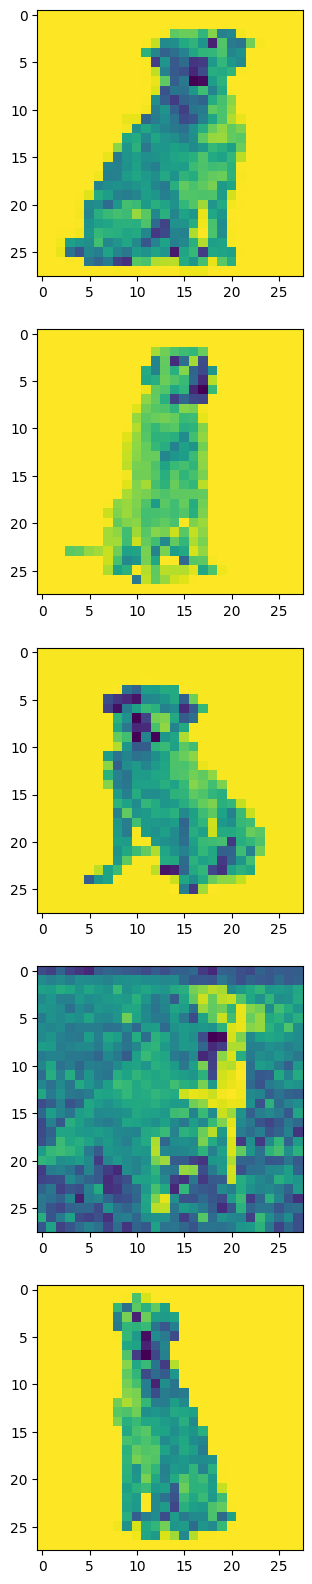

In [8]:
img_width = 28
img_height = 28

dim = (img_width, img_height)

doggos = [
    "./labrador1.jpg",
    "./labrador2.jpg",
    "./labrador3.jpg",
    "./labrador4.jpg",
    "./labrador5.jpg"
]

images = []

for doggo in doggos:
    img = cv2.imread(doggo, 0) / 255 # read as grayscale 1 channel images and normalize
    
    img = cv2.resize(img, dim)
    
    images.append(img)

num_images = len(images)
num_cols   = 1

col_names = [
    "Original"
]

fig, axes = plt.subplots(nrows=num_images, ncols=num_cols, figsize=(num_cols*4, num_images*4))
counter = 0

for img in images:
    counter += 1
    
    plt.subplot(len(images), num_cols, counter)
    plt.imshow(img)

In [9]:
data = []

for img in images:
    data.append(img.ravel())

x = torch.Tensor(np.array(data))

# use Dataloader for Autoencoder 
custom_dataset = AutoencoderDataset(x)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [10]:
epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    state = { 'state_dict': model.state_dict() }

    torch.save(state, "variational-autoencoder.pth")

Epoch: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 58.12it/s, loss=1.3]


Ave Loss: 1.5788950681686402
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 122.71it/s, loss=0.719]


Ave Loss: 0.8594530701637269
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 119.87it/s, loss=0.509]

Ave Loss: 0.6518572211265564
Epoch: 3



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 125.03it/s, loss=0.479]


Ave Loss: 0.5810280680656433
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 127.56it/s, loss=0.319]


Ave Loss: 0.5339836359024048
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 128.18it/s, loss=0.359]


Ave Loss: 0.5024035155773163
Epoch: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 113.89it/s, loss=0.3]


Ave Loss: 0.45305247902870177
Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 128.86it/s, loss=0.34]


Ave Loss: 0.4891809046268463
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 122.49it/s, loss=0.263]


Ave Loss: 0.43537882566452024
Epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.86it/s, loss=0.304]


Ave Loss: 0.4569814622402191
Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.66it/s, loss=0.295]


Ave Loss: 0.4543206036090851
Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.98it/s, loss=0.336]


Ave Loss: 0.504978346824646
Epoch: 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 91.37it/s, loss=0.264]


Ave Loss: 0.500465041399002
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 103.52it/s, loss=0.268]

Ave Loss: 0.4471946477890015
Epoch: 14



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 113.11it/s, loss=0.276]


Ave Loss: 0.41097491979599
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 114.84it/s, loss=0.298]


Ave Loss: 0.5303419411182404
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 110.76it/s, loss=0.286]


Ave Loss: 0.4380100190639496
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 114.03it/s, loss=0.309]


Ave Loss: 0.49592846632003784
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 127.57it/s, loss=0.338]


Ave Loss: 0.4572990447282791
Epoch: 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 89.43it/s, loss=0.282]


Ave Loss: 0.43642043471336367
Epoch: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 123.00it/s, loss=0.3]


Ave Loss: 0.4902949869632721
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 115.04it/s, loss=0.292]


Ave Loss: 0.47425124049186707
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 115.19it/s, loss=0.254]


Ave Loss: 0.4271264374256134
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 130.16it/s, loss=0.245]


Ave Loss: 0.43156794309616087
Epoch: 24


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 132.56it/s, loss=0.36]


Ave Loss: 0.43912439942359927
Epoch: 25


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 80.64it/s, loss=0.347]


Ave Loss: 0.4481711506843567
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 121.47it/s, loss=0.324]


Ave Loss: 0.4883056402206421
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 144.03it/s, loss=0.327]


Ave Loss: 0.506798779964447
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 128.57it/s, loss=0.321]


Ave Loss: 0.5005070954561234
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 127.36it/s, loss=0.381]


Ave Loss: 0.4480633348226547
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 123.58it/s, loss=0.302]


Ave Loss: 0.4421755373477936
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 123.16it/s, loss=0.273]

Ave Loss: 0.4696685552597046


Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 126.63it/s, loss=0.334]


Ave Loss: 0.4328130125999451
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 131.08it/s, loss=0.324]


Ave Loss: 0.45841798186302185
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 131.56it/s, loss=0.249]


Ave Loss: 0.45711395144462585
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 130.60it/s, loss=0.276]


Ave Loss: 0.41333377957344053
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 125.64it/s, loss=0.365]


Ave Loss: 0.46644909381866456
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 112.81it/s, loss=0.313]

Ave Loss: 0.48606249690055847


Epoch: 38


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 84.91it/s, loss=0.353]


Ave Loss: 0.4947072148323059
Epoch: 39


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 72.12it/s, loss=0.289]


Ave Loss: 0.47622120976448057
Epoch: 40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 84.19it/s, loss=0.284]


Ave Loss: 0.46747300028800964
Epoch: 41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 88.07it/s, loss=0.311]


Ave Loss: 0.41220343708992
Epoch: 42


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 84.45it/s, loss=0.322]


Ave Loss: 0.5005958557128907
Epoch: 43


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 87.88it/s, loss=0.288]


Ave Loss: 0.47738621234893797
Epoch: 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 87.99it/s, loss=0.34]


Ave Loss: 0.4510809421539307
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 100.96it/s, loss=0.284]


Ave Loss: 0.4868134319782257
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 124.22it/s, loss=0.308]


Ave Loss: 0.47953103184700013
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 126.58it/s, loss=0.337]


Ave Loss: 0.456941157579422
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 120.93it/s, loss=0.293]


Ave Loss: 0.4712622344493866
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 132.02it/s, loss=0.291]


Ave Loss: 0.4468502223491669
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 140.12it/s, loss=0.308]


Ave Loss: 0.44337172508239747
Epoch: 51


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 138.01it/s, loss=0.336]


Ave Loss: 0.4931280970573425
Epoch: 52


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 142.79it/s, loss=0.267]


Ave Loss: 0.48132056593894956
Epoch: 53


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 141.31it/s, loss=0.264]


Ave Loss: 0.49232099652290345
Epoch: 54


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 133.93it/s, loss=0.281]


Ave Loss: 0.46823397278785706
Epoch: 55


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 129.63it/s, loss=0.384]


Ave Loss: 0.48098592162132264
Epoch: 56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 129.89it/s, loss=0.304]


Ave Loss: 0.4707868754863739
Epoch: 57


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 144.93it/s, loss=0.351]


Ave Loss: 0.43787921667099
Epoch: 58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 130.45it/s, loss=0.278]


Ave Loss: 0.4598170042037964
Epoch: 59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 123.52it/s, loss=0.285]


Ave Loss: 0.5063543617725372
Epoch: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 129.73it/s, loss=0.261]


Ave Loss: 0.5016501724720002
Epoch: 61


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 131.15it/s, loss=0.294]


Ave Loss: 0.4509980916976929
Epoch: 62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 141.82it/s, loss=0.279]


Ave Loss: 0.4662136971950531
Epoch: 63


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 128.66it/s, loss=0.247]


Ave Loss: 0.4586785763502121
Epoch: 64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 130.99it/s, loss=0.322]


Ave Loss: 0.423873770236969
Epoch: 65


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 130.07it/s, loss=0.288]


Ave Loss: 0.4614089488983154
Epoch: 66


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 122.85it/s, loss=0.29]


Ave Loss: 0.445598828792572
Epoch: 67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 117.15it/s, loss=0.267]


Ave Loss: 0.4452555596828461
Epoch: 68


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 119.23it/s, loss=0.237]


Ave Loss: 0.5529949307441712
Epoch: 69


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 99.71it/s, loss=0.323]


Ave Loss: 0.49842849373817444
Epoch: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 100.53it/s, loss=0.301]


Ave Loss: 0.44951077103614806
Epoch: 71


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 98.57it/s, loss=0.232]


Ave Loss: 0.4785035640001297
Epoch: 72


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 101.95it/s, loss=0.315]


Ave Loss: 0.3987181603908539
Epoch: 73


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 88.34it/s, loss=0.349]


Ave Loss: 0.48843103647232056
Epoch: 74


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 122.27it/s, loss=0.237]


Ave Loss: 0.4307160586118698
Epoch: 75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 124.39it/s, loss=0.381]


Ave Loss: 0.478554892539978
Epoch: 76


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 112.51it/s, loss=0.37]


Ave Loss: 0.4852840185165405
Epoch: 77


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 112.75it/s, loss=0.295]


Ave Loss: 0.455218106508255
Epoch: 78


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 110.73it/s, loss=0.294]


Ave Loss: 0.43253323435783386
Epoch: 79


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 100.89it/s, loss=0.279]


Ave Loss: 0.47353864312171934
Epoch: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 126.73it/s, loss=0.394]


Ave Loss: 0.5106198072433472
Epoch: 81


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 114.28it/s, loss=0.243]


Ave Loss: 0.4234109878540039
Epoch: 82


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 136.36it/s, loss=0.35]


Ave Loss: 0.5089233160018921
Epoch: 83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 123.15it/s, loss=0.376]


Ave Loss: 0.44587087631225586
Epoch: 84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 126.07it/s, loss=0.287]


Ave Loss: 0.4613398611545563
Epoch: 85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 126.74it/s, loss=0.269]


Ave Loss: 0.47584792971611023
Epoch: 86


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 136.92it/s, loss=0.359]


Ave Loss: 0.4558752954006195
Epoch: 87


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 138.28it/s, loss=0.286]


Ave Loss: 0.4525905609130859
Epoch: 88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 110.73it/s, loss=0.318]


Ave Loss: 0.42103007435798645
Epoch: 89


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 96.08it/s, loss=0.3]


Ave Loss: 0.4423788070678711
Epoch: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 123.48it/s, loss=0.242]


Ave Loss: 0.5133655518293381
Epoch: 91


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 136.75it/s, loss=0.253]


Ave Loss: 0.4517707824707031
Epoch: 92


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 103.22it/s, loss=0.258]


Ave Loss: 0.5332266569137574
Epoch: 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 127.41it/s, loss=0.253]


Ave Loss: 0.45096070468425753
Epoch: 94


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 143.75it/s, loss=0.231]


Ave Loss: 0.5040657758712769
Epoch: 95


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.94it/s, loss=0.277]


Ave Loss: 0.43385018706321715
Epoch: 96


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 137.98it/s, loss=0.253]


Ave Loss: 0.49141037464141846
Epoch: 97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 120.14it/s, loss=0.278]


Ave Loss: 0.44602710008621216
Epoch: 98


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 125.69it/s, loss=0.268]


Ave Loss: 0.49779021739959717
Epoch: 99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 135.43it/s, loss=0.351]


Ave Loss: 0.4266183853149414


In [40]:
sampled_mu = torch.Tensor([np.zeros(num_features)])
sampled_logvar = torch.Tensor([np.zeros(num_features)])

print(sampled_logvar)

sampled_logvar.shape

tensor([[0., 0., 0., 0., 0., 0., 0., 0.]])


torch.Size([1, 8])

In [41]:
reconstruction = model.sample(sampled_mu, sampled_logvar)

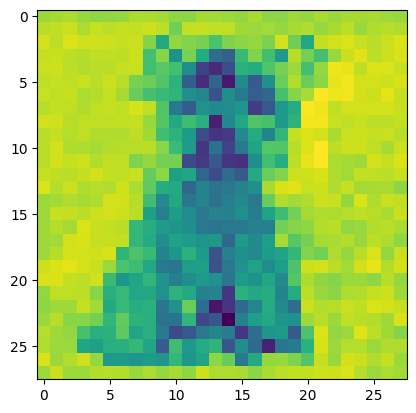

In [42]:
reconstructed_image = reconstruction[0].detach().cpu().numpy()
reconstructed_image = reconstructed_image.reshape(img_width, img_height)
plt.imshow(reconstructed_image)